In [1]:
import numpy as np
import scipy.sparse as sparse
import scipy
import cvxpy as cp
import matplotlib.pyplot as plt
import dyn_on_U_dagger as api

np.random.seed(0)

In [152]:
# Initialize parameters and SDR constraint
N_omega = 11
omega = np.linspace(-2, 2, N_omega)
N_z = 2
z = np.linspace(0, 2*10**-3, N_z)
delta_z = np.abs(z[1] - z[0])
green_fs = api.get_green_f(omega,z)
projection = np.zeros((N_omega, N_omega))
projections = []
sdr_def_constr = []
sdr_cst = []
for i in range(N_omega):
    for j in range(N_omega):
        proj_copy = projection.copy()
        proj_copy[i, j] = 1
        projections.append(sparse.csc_matrix(proj_copy))
        sdr_def_constr.append(api.sdr_def_constr(N_omega, N_z, sparse.csc_matrix(proj_copy)))
        if i == j:
            sdr_cst.append(2.)
        else:
            sdr_cst.append(0.)

In [153]:
beta_vec = np.random.random(2*N_omega - 1)#np.exp(-(np.linspace(omega[0], omega[-1], 2*N_omega - 1)**2)/0.2)#
beta = scipy.linalg.hankel(beta_vec[:N_omega], beta_vec[N_omega - 1:])
new_beta = beta/np.sqrt(np.trace(beta.conj().T@beta))
beta_weight = 20
delta_k = 1.j*np.diag(omega)
Q_plus = delta_k + beta_weight*new_beta
Q_minus = delta_k - beta_weight*new_beta
W_plus = [scipy.linalg.expm(Q_plus*z[i]) for i in range(N_z)]
W_minus = [scipy.linalg.expm(Q_minus*z[i]) for i in range(N_z)]
J = 0.25*(W_plus[-1]@W_plus[-1].conj().T + W_minus[-1]@W_minus[-1].conj().T - 2*np.eye(N_omega))
n = 0.25*np.trace((W_plus[-1] - W_minus[-1]).conj().T@(W_plus[-1] - W_minus[-1]))
W, _, V = scipy.linalg.svd((0.5/np.sqrt(n))*(scipy.linalg.expm((delta_k + beta)*z[-1]) - scipy.linalg.expm((delta_k - beta)*z[-1])))
rand_unitary = W@V
W_plus = [(1/np.sqrt(n))*rand_unitary.conj().T@scipy.linalg.expm(Q_plus*z[i]) for i in range(N_z)]
W_minus = [(1/np.sqrt(n))*rand_unitary.conj().T@scipy.linalg.expm(Q_minus*z[i]) for i in range(N_z)]
X = np.vstack([rand_unitary] + W_plus + W_minus + [new_beta])
Y = np.vstack([rand_unitary] + W_plus + W_minus + [new_beta, np.eye(N_omega)])
full_rank = Y@Y.conj().T

In [154]:
# Get dynamics constraints
real_hermitian_obj_f_mat = []
imag_hermitian_obj_f_mat = []
dynamics_mat = []
sympl_mat = []
unit_mat = []
pump_mat = []
nbr_elements_rank_one = 200
prev_photon_nbr = api.photon_nbr_prev_points(N_omega, N_z)
photon_nbr_end = api.photon_nbr_constr(N_omega, N_z, n)
B_U_and_U_ineq = api.ineq_U_and_B_U(N_omega, N_z)
Q_list = api.gen_Q_mat(N_omega, 200) + api.gen_standard_Q_mat(N_omega)
unitary_ineq = api.real_ineq_Q(N_omega, N_z, Q_list)
imag_equal = api.imag_constr_tr_B_U(N_omega, N_z)
hankel_constr = api.constr_hankel_sdr(N_omega, N_z)
_, rank_one_mat = api.random_rank_one_mat(N_omega, nbr_elements_rank_one)
real_semidef_obj_f, imag_semidef_obj_f = api.constr_semidefinite_obj_f(N_omega, N_z, rank_one_mat)
for i in range(len(projections)):
    real_hermitian_obj_f, imag_hermitian_obj_f = api.constr_obj_f_hermitian(N_omega, N_z, projections[i])
    real_plus, imag_plus, real_minus, imag_minus = api.get_dynamics_sdr(omega, z, n, projections[i], beta_weight)
    unitary_real, unitary_imag = api.unitary_constr(N_omega, N_z, projections[i])
    sympl_real, sympl_imag = api.sympl_constr_sdr(N_omega, N_z, projections[i], n)
    fix_beta_real, fix_beta_imag = api.sdr_fixed_pump(N_omega, N_z, new_beta, projections[i])
    dynamics_mat += real_plus + imag_plus + real_minus + imag_minus
    sympl_mat += sympl_real + sympl_imag
    unit_mat += [unitary_real] + [unitary_imag]
    pump_mat += [fix_beta_imag, fix_beta_real]
    real_hermitian_obj_f_mat.append(real_hermitian_obj_f)
    imag_hermitian_obj_f_mat.append(imag_hermitian_obj_f)
constraints_list = dynamics_mat + sympl_mat  + [photon_nbr_end] + unit_mat + pump_mat + hankel_constr + real_hermitian_obj_f_mat + imag_hermitian_obj_f_mat# + imag_semidef_obj_f
left_sdp, right_sdp, quad_sdp_plus, quad_sdp_minus = api.obj_f_sdr(N_omega, N_z)
sdp_cst_term = (0.5/n)*np.eye(N_omega)
constr_pump_power = api.limit_pump_power(N_omega, N_z)

In [156]:
[(np.trace(Y.conj().T@constraints_list[i]@Y), i) for i in range(len(constraints_list)) if np.abs(np.trace(Y.conj().T@constraints_list[i]@Y)) > 10*10**-5]

[]

In [157]:
[np.trace(Y.conj().T@sdr_def_constr[i]@Y) - sdr_cst[i] for i in range(len(sdr_def_constr)) if np.abs(np.trace(Y.conj().T@sdr_def_constr[i]@Y) - sdr_cst[i]) > 10**-6]

[]

In [158]:
np.trace(Y.conj().T@photon_nbr_end@Y)

(2.881210894867259e-13+0j)

In [159]:
[np.trace(Y.conj().T@prev_photon_nbr[i]@Y) for i in range(len(prev_photon_nbr))]

[(1.0000000000001454+0j)]

In [160]:
[np.trace(Y.conj().T@unitary_ineq[i]@Y) for i in range(len(unitary_ineq)) if np.trace(Y.conj().T@unitary_ineq[i]@Y) < 0]

[]

In [161]:
np.trace(Y.conj().T@imag_equal@Y)

(-4.41450532812776e-15+0j)

In [162]:
# Objective function
obj_f_mat = api.obj_f(N_omega, N_z)

In [184]:
# Build cvxpy model
variable = cp.Variable(shape=((2*N_z + 3)*N_omega,(2*N_z + 3)*N_omega), hermitian = True)
constraints = [variable >> 0]
# Constraint telling objective function block is PSD
constraints += [0.5*left_sdp.conj().T@variable@right_sdp>>0] #- (quad_sdp_plus.conj().T@variable@quad_sdp_plus + quad_sdp_minus.conj().T@variable@quad_sdp_minus - sdp_cst_term) >> 0]
constraints += [cp.real(cp.trace(constraints_list[i]@variable)) == 0 for i in range(len(constraints_list))]
constraints += [cp.real(cp.trace(prev_photon_nbr[i]@variable)) >= 0 for i in range(len(prev_photon_nbr))]
constraints += [cp.real(cp.trace(sdr_def_constr[i]@variable)) == sdr_cst[i] for i in range(len(sdr_def_constr))]
constraints += [cp.real(cp.trace(unitary_ineq[i]@variable)) >= 0 for i in range(len(unitary_ineq))]


# Constraint to make the matrix of objective function positive semidefinite
#constraints += [cp.real(cp.trace(real_semidef_obj_f[i]@variable)) >= 0 for i in range(len(real_semidef_obj_f))]


constraints.append(cp.real(cp.trace(photon_nbr_end@variable)) == 0)
# This constraint make the bound better :D
#constraints.append(cp.real(cp.trace(B_U_and_U_ineq@variable)) >= 0)
# Constraint making imaginary part of trace of U_+ - U_- nothing
#constraints.append(cp.real(cp.trace(imag_equal@variable)) == 0)
# Constraint to limit the power of pump
constraints.append(cp.real(cp.trace(constr_pump_power@variable)) == 0)
problem = cp.Problem(cp.Minimize(cp.real(cp.trace(obj_f_mat@variable))), constraints)

In [185]:
problem.solve(solver = cp.SCS, verbose = True, max_iters = 5*10**4, eps_abs = 1.0e-08, eps_rel = 1.0e-08, eps_infeas = 1.0e-10)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Mar 27 05:44:33 PM: Your problem has 5929 variables, 2629 constraints, and 0 parameters.
(CVXPY) Mar 27 05:44:33 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 27 05:44:33 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 27 05:44:33 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 27 05:44:33 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 27 05:44:33 PM: Compiling problem (target solver=SCS).


-2.0990001559778593e-08

In [186]:
end_product = variable.value

In [188]:
[np.trace(constraints_list[i]@end_product) for i in range(len(constraints_list)) if np.abs(np.trace(constraints_list[i]@end_product)) > 2*10**-6]

[]

In [189]:
# Get elements of the optimized_result
opt_unit = end_product[:N_omega, (2*N_z + 2)*N_omega:]
opt_U_plus_Z_dagger = end_product[N_z*N_omega:(N_z + 1)*N_omega,(2*N_z + 2)*N_omega:(2*N_z + 3)*N_omega]
opt_U_minus_Z_dagger = end_product[2*N_z*N_omega:(2*N_z + 1)*N_omega,(2*N_z + 2)*N_omega:(2*N_z + 3)*N_omega]
opt_beta_Z_dagger = end_product[(2*N_z + 1)*N_omega:(2*N_z + 2)*N_omega,(2*N_z + 2)*N_omega:(2*N_z + 3)*N_omega]
opt_U_plus_U_plus_dagger = end_product[N_z*N_omega:(N_z + 1)*N_omega,N_z*N_omega:(N_z + 1)*N_omega]
opt_U_minus_U_minus_dagger = end_product[2*N_z*N_omega:(2*N_z + 1)*N_omega,2*N_z*N_omega:(2*N_z + 1)*N_omega]

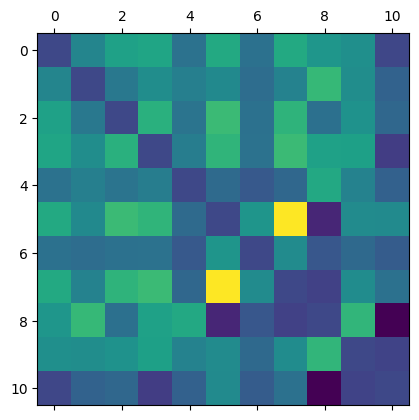

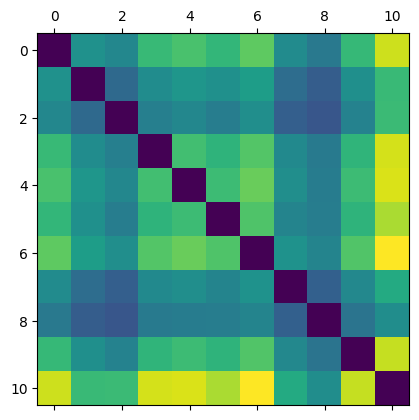

In [190]:
plt.matshow(np.real(opt_U_plus_Z_dagger@opt_U_plus_Z_dagger.conj().T - np.diag(np.diag(opt_U_plus_Z_dagger@opt_U_plus_Z_dagger.conj().T))))
plt.matshow(np.real(opt_U_plus_U_plus_dagger - np.diag(np.diag(opt_U_plus_U_plus_dagger))))

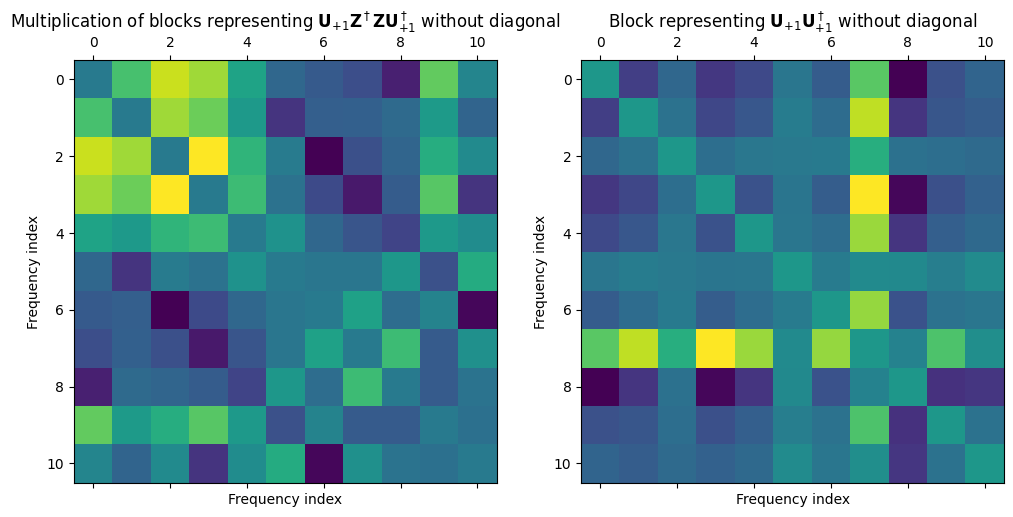

In [55]:
# Dont think it sees the lin vs quad very well
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12, 8))
ax1.set_title(r"Multiplication of blocks representing $\mathbf{U}_{+1}\mathbf{Z}^\dagger\mathbf{Z}\mathbf{U}_{+1}^\dagger$ without diagonal")
ax1.set_xlabel('Frequency index')
ax1.set_ylabel('Frequency index')
ax1.matshow(np.real(opt_U_plus_dagger_1.conj().T@opt_U_plus_dagger_1 - np.diag(np.diag(opt_U_plus_dagger_1.conj().T@opt_U_plus_dagger_1))))
ax2.set_title(r"Block representing $\mathbf{U}_{+1}\mathbf{U}_{+1}^\dagger$ without diagonal")
ax2.set_xlabel('Frequency index')
ax2.set_ylabel('Frequency index')
ax2.matshow(np.real(end_product[2*N_z*N_omega:(2*N_z + 1)*N_omega, 2*N_z*N_omega:(2*N_z + 1)*N_omega] - np.diag(np.diag(end_product[2*N_z*N_omega:(2*N_z + 1)*N_omega, 2*N_z*N_omega:(2*N_z + 1)*N_omega]))))

In [48]:
U_plus = [scipy.linalg.expm((delta_k + beta)*i) for i in np.linspace(0, 2*10**-2, 10)]
U_minus = [scipy.linalg.expm((delta_k - beta)*i) for i in np.linspace(0, 2*10**-2, 10)]
green = api.get_green_f(omega, np.linspace(0, 2*(10**-2), 10))
green.reverse()
green[0] = 0.5*green[0]
green[-1] = 0.5*green[-1]
delta_z = np.abs(np.linspace(0, 2*10**-2, 10)[1] - np.linspace(0, 2*10**-2, 10)[0])
test_norml = 2*green[0] - delta_z*sum([green[i]@beta@U_minus[i] for i in range(len(U_plus))]) - U_minus[-1]
test_swapped = 2*green[0] - delta_z*sum([U_minus[i]@beta@green[i] for i in range(len(U_plus))]) - U_minus[-1]
test_dagger = 2*green[0].conj().T - delta_z*sum([green[i].conj().T@beta@U_minus[i].conj().T for i in range(len(U_plus))]) - U_minus[-1].conj().T
test_dagger_as_it_is = 2*green[0].conj().T - delta_z*sum([U_minus[i].conj().T@beta@green[i].conj().T for i in range(len(U_plus))]) - U_minus[-1].conj().T

In [34]:
np.max(np.abs(np.real(test_dagger))), np.max(np.abs(np.imag(test_dagger)))

(2.55767970136489e-07, 2.3508320190023596e-07)

In [22]:
np.linspace(0, 2*10**-2, 10)

array([0.        , 0.00222222, 0.00444444, 0.00666667, 0.00888889,
       0.01111111, 0.01333333, 0.01555556, 0.01777778, 0.02      ])

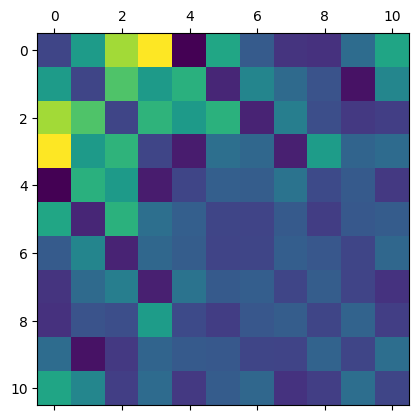

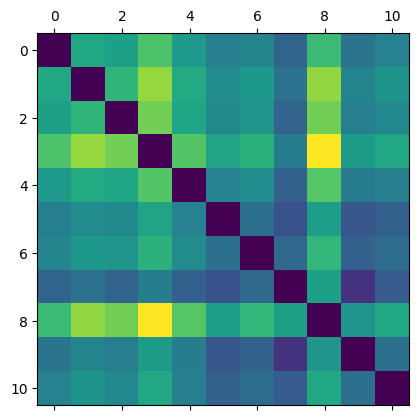

In [21]:
# When the positive semidefinite constraint not enforced. The linear and quadratic form dont follow each other...
plt.matshow(np.real(opt_U_plus_dagger_1@opt_U_plus_dagger_1.conj().T - np.diag(np.diag(opt_U_plus_dagger_1@opt_U_plus_dagger_1.conj().T))))
plt.matshow(np.real(end_product[2*N_omega:3*N_omega, 2*N_omega:3*N_omega] - np.diag(np.diag(end_product[2*N_omega:3*N_omega, 2*N_omega:3*N_omega]))))

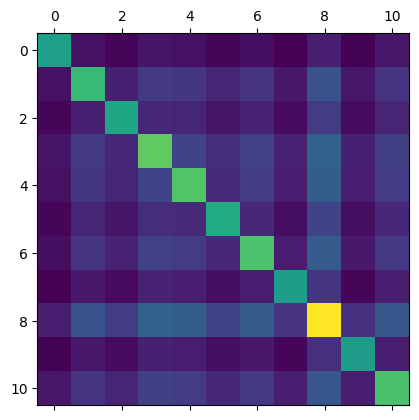

In [30]:
plt.matshow(np.real(opt_B_U_plus_dagger.conj().T@opt_B_U_plus_dagger))

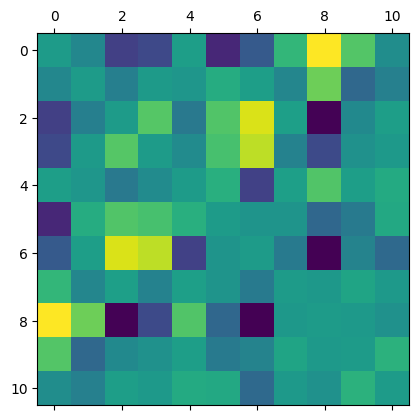

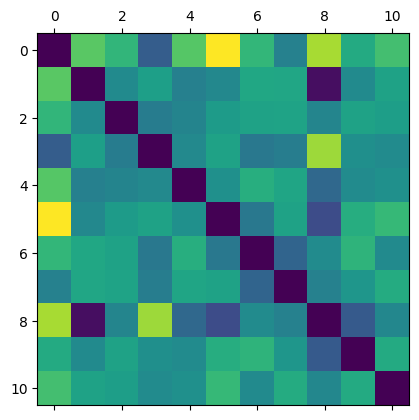

In [28]:
# Check for if opt_U_plus_dagger_1 - opt_U_minus_dagger_1 is diagonalizable and B is unitary or not
plt.matshow(np.real(opt_U_plus_dagger_1.conj().T@opt_U_plus_dagger_1 - np.diag(np.diag(opt_U_plus_dagger_1.conj().T@opt_U_plus_dagger_1))))
plt.matshow(np.real(end_product[2*N_omega:3*N_omega, 2*N_omega:3*N_omega] - np.diag(np.diag(end_product[2*N_omega:3*N_omega, 2*N_omega:3*N_omega]))))

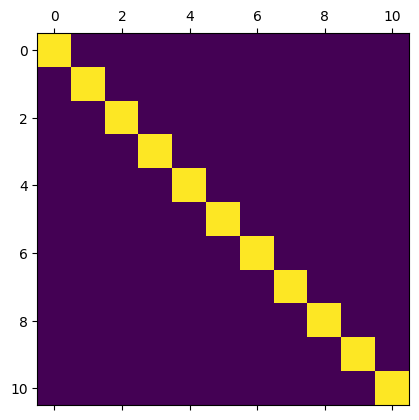

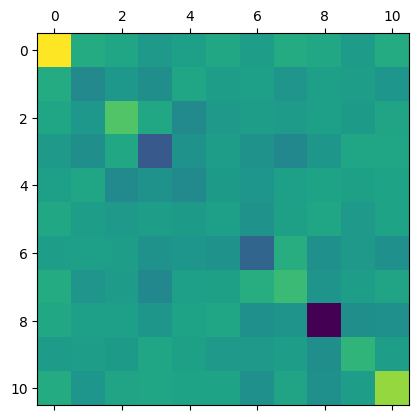

In [23]:
plt.matshow(np.real(0.25*(end_product[2*N_omega:3*N_omega, 2*N_omega:3*N_omega] + end_product[2*N_z*N_omega:(2*N_z + 1)*N_omega, 2*N_z*N_omega:(2*N_z + 1)*N_omega] - (2/n)*np.eye(N_omega))))
plt.matshow(np.real(opt_U_plus_dagger_1 - opt_U_minus_dagger_1))

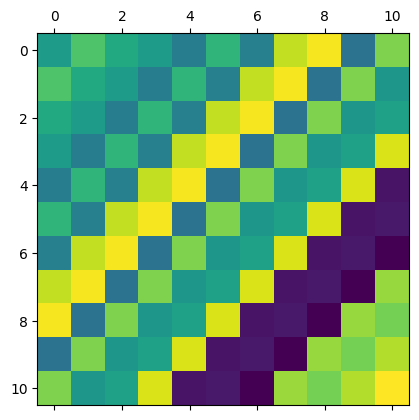

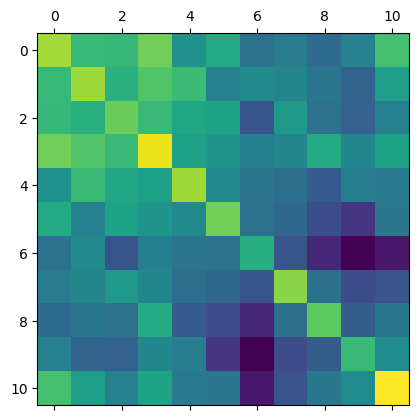

In [47]:
plt.matshow(np.real(0.5*rand_unitary.conj().T@(W_plus[1] - W_minus[1])))
plt.matshow(np.real(0.25*(W_plus[1] - W_minus[1])@(W_plus[1] - W_minus[1]).conj().T))

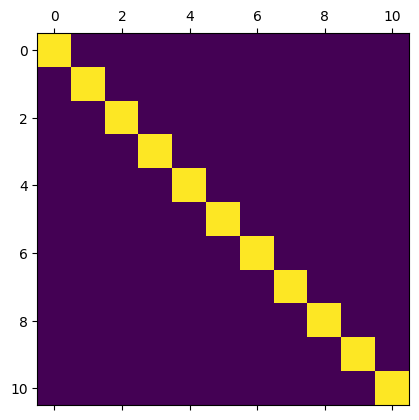

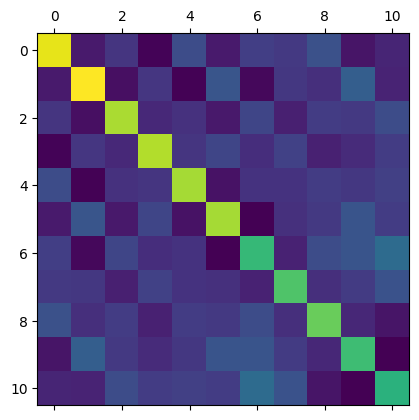

In [18]:
# Interesing. If obj f is 0, the tilde U_plus goes to 0...
plt.matshow(np.real(end_product[N_z*N_omega:(N_z + 1)*N_omega, N_z*N_omega:(N_z + 1)*N_omega]))
plt.matshow(np.real(opt_U_plus_dagger_1.conj().T@opt_U_plus_dagger_1))

In [19]:
(np.real(end_product[:,N_omega:2*N_omega]))

array([[ 1.59696083e+01, -4.57064281e-02, -3.12719514e+00,
        -2.67187641e+00,  1.50892676e+00,  1.02675400e+00,
        -1.83075023e+00,  9.56244784e-02,  4.66848608e-01,
        -2.95564803e+00, -1.23952867e+00],
       [-2.98169190e-01,  1.26084640e+01, -3.56914599e+00,
        -2.77133123e-01, -5.41449238e-01, -1.41344505e-01,
        -1.68994016e+00,  2.17343085e-01, -3.91408601e-01,
         1.63745424e+00, -1.52098177e-01],
       [-3.22148225e+00, -3.67406859e+00,  1.41872836e+01,
         1.02878572e-01, -1.51499278e+00, -7.60063432e-01,
         1.18581311e+00, -1.16045559e+00, -1.20922893e+00,
         4.36551193e-01,  2.88453122e+00],
       [-2.67267656e+00, -3.02043710e-01,  5.27779702e-02,
         1.02306694e+01, -1.20727545e+00,  3.09450393e-01,
         1.02257760e+00, -4.28202548e-01,  9.19435720e-01,
        -7.79153533e-01,  5.33718436e-02],
       [ 1.52597232e+00, -4.65483010e-01, -1.53468556e+00,
        -1.17750924e+00,  1.34520150e+01, -2.14875941e+00,
  

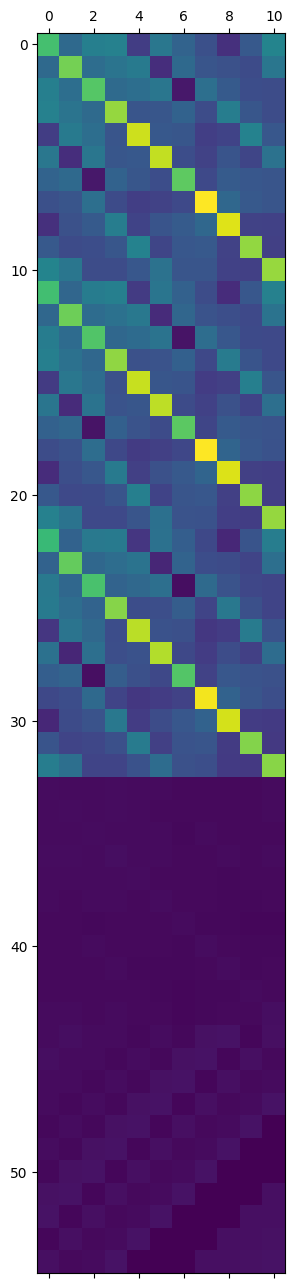

In [20]:
plt.matshow(np.real(end_product[N_z*N_omega:,(2*N_z + 1)*N_omega:(2*N_z + 2)*N_omega]))

In [21]:
end_product[:N_omega,N_omega:]

array([[ 1.59696083e+01+1.26982988e-01j, -4.57064281e-02-2.91564900e-02j,
        -3.12719514e+00+6.99766805e-02j, -2.67187641e+00+2.29836812e-03j,
         1.50892676e+00-2.00732836e-01j,  1.02675400e+00-1.16610582e-03j,
        -1.83075023e+00+1.30286393e-02j,  9.56244784e-02-3.98903790e-02j,
         4.66848608e-01-1.08962676e-01j, -2.95564803e+00+4.67048686e-02j,
        -1.23952867e+00-3.59134684e-01j,  1.60032507e+01+9.06083139e-02j,
         2.44865055e-02+1.03062113e-02j, -3.07359968e+00+7.63414484e-02j,
        -2.66086302e+00-4.82138914e-03j,  1.56876061e+00-1.72417792e-01j,
         1.11324172e+00-3.21603231e-02j, -1.79237253e+00+5.62267900e-02j,
         1.79455617e-01-3.01023137e-02j,  5.58307932e-01-7.78218862e-02j,
        -2.96735975e+00+4.11780500e-02j, -1.17865864e+00-3.88404353e-01j,
         1.61182039e+01+1.11741348e-01j,  2.18382731e-02-2.00625900e-02j,
        -3.05020105e+00+9.15841275e-02j, -2.57345383e+00+8.25417700e-03j,
         1.55634415e+00-2.15782312e-01

In [22]:
np.linalg.svd(left_sdp.conj().T@end_product@right_sdp)[1], np.linalg.svd(W_plus[1] - W_minus[1])[1]

(array([0.76742679, 0.20056493, 0.19186616, 0.17208572, 0.15573037,
        0.14115781, 0.12434948, 0.08644339, 0.06098764, 0.04516752,
        0.01514139]),
 array([1.80606031, 0.44555176, 0.37178655, 0.32457709, 0.31137807,
        0.26320465, 0.25098518, 0.23384838, 0.09203786, 0.05620347,
        0.0226464 ]))

In [23]:
# Program drives the blocks that are constrained to be a certain values to these values, but the rest are being driven to 0.
[np.trace(real_semidef_obj_f[i]@end_product) for i in range(len(real_semidef_obj_f))]

[(2.008351212146639-8.743006318923108e-15j),
 (2.2250737738560957-4.6629367034256575e-15j),
 (2.0612755404898166-3.747002708109903e-15j),
 (1.312624608716682+1.1102230246251565e-15j),
 (1.9169723698576533+2.886579864025407e-15j),
 (2.392271917029124+6.661338147750939e-15j),
 (1.9064491200344307-3.3306690738754696e-15j),
 (1.4866447694010176-3.608224830031759e-15j),
 (1.6091163546107559+2.886579864025407e-15j),
 (3.0519087365965056-3.2751579226442118e-15j),
 (1.758229552628265-2.3314683517128287e-15j),
 (2.932663214427457+1.7763568394002505e-15j),
 (4.762358442967976+6.689093723366568e-15j),
 (1.9653171901298663-9.298117831235686e-15j),
 (1.8611316537121425+1.7763568394002505e-15j),
 (2.075439755144627+1.609823385706477e-15j),
 (2.432453411213549+8.881784197001252e-15j),
 (4.3056405597209455-1.3877787807814457e-16j),
 (2.0821593362486515+3.774758283725532e-15j),
 (2.7326836148836406+6.050715484207103e-15j),
 (3.0980368481522618+3.608224830031759e-15j),
 (3.265093020018412+1.443289932012

In [24]:
np.linalg.eigvalsh((opt_U_plus_dagger_1 - opt_U_minus_dagger_1))

array([0.01514139, 0.04516751, 0.06098766, 0.0864434 , 0.12434949,
       0.14115778, 0.15573037, 0.1720857 , 0.19186617, 0.20056491,
       0.76742683])

In [25]:
pump = np.array(list(opt_beta[0]) + list(opt_beta[-1]))
test_W_plus = scipy.linalg.expm((delta_k + beta_weight*opt_beta)*z[-1])
test_W_minus = scipy.linalg.expm((delta_k - beta_weight*opt_beta)*z[-1])

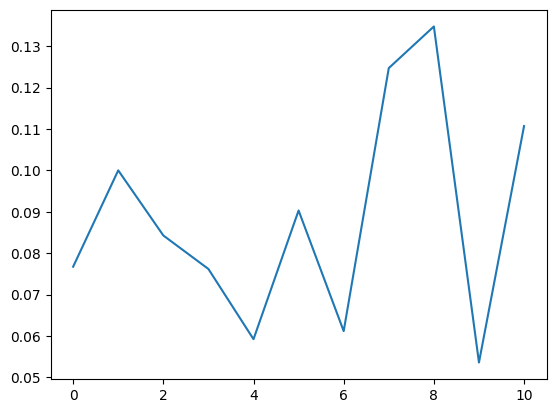

In [26]:
plt.plot(new_beta[0])

/home/jiaqizhao/miniconda3/envs/cvxpy_opt/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


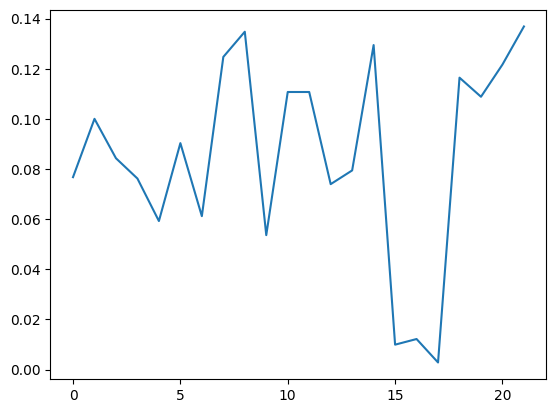

In [27]:
plt.plot(pump)

In [28]:
(scipy.linalg.svd(test_W_plus - test_W_minus)[1])

array([0.07225503, 0.01782519, 0.01487407, 0.01298536, 0.0124573 ,
       0.01053003, 0.01004117, 0.00935557, 0.00368217, 0.00224853,
       0.00090598])

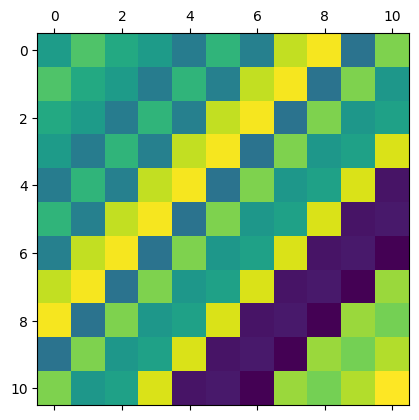

In [29]:
plt.matshow(np.real(opt_beta))

In [30]:
# The block beta dagger beta is not the same as (Zbeta dagger)dagger (Zbeta)...
(np.real(end_product[(2*N_z + 1)*N_omega:(2*N_z + 2)*N_omega, (2*N_z + 1)*N_omega:(2*N_z + 2)*N_omega]))

array([[0.09307324, 0.08372957, 0.08349278, 0.08927898, 0.07582698,
        0.08078671, 0.06917934, 0.07142183, 0.06788391, 0.07215328,
        0.08519875],
       [0.08372957, 0.09265632, 0.08193019, 0.08659513, 0.08416378,
        0.07218051, 0.07406289, 0.07309359, 0.06989944, 0.06654121,
        0.07816204],
       [0.08349278, 0.08193019, 0.08896148, 0.08378048, 0.07976258,
        0.07920548, 0.06336868, 0.07719223, 0.06926534, 0.06608501,
        0.0720496 ],
       [0.08927898, 0.08659513, 0.08378048, 0.09861493, 0.07864228,
        0.07634301, 0.07195453, 0.07328662, 0.08076719, 0.07365422,
        0.07928155],
       [0.07582698, 0.08416378, 0.07976258, 0.07864228, 0.09290793,
        0.07424859, 0.06948854, 0.0684462 , 0.0648626 , 0.07170542,
        0.07092728],
       [0.08078671, 0.07218051, 0.07920548, 0.07634301, 0.07424859,
        0.08954605, 0.06893125, 0.06727976, 0.06238332, 0.05835986,
        0.07019427],
       [0.06917934, 0.07406289, 0.06336868, 0.07195453, 0.

In [31]:
(np.real(opt_beta.conj().T@opt_beta))

array([[0.09307745, 0.08372339, 0.08348336, 0.08926993, 0.07582413,
        0.0807794 , 0.06917257, 0.0714176 , 0.06788164, 0.0721473 ,
        0.08518916],
       [0.08372339, 0.09265761, 0.08192262, 0.08658813, 0.08415589,
        0.07217786, 0.0740554 , 0.07308857, 0.06989487, 0.06653744,
        0.0781548 ],
       [0.08348336, 0.08192262, 0.08896447, 0.08377465, 0.07975535,
        0.0791977 , 0.0633675 , 0.07718497, 0.06925973, 0.06608096,
        0.07204651],
       [0.08926993, 0.08658813, 0.08377465, 0.09861495, 0.0786368 ,
        0.07633806, 0.071949  , 0.07328209, 0.08075899, 0.07364913,
        0.07927701],
       [0.07582413, 0.08415589, 0.07975535, 0.0786368 , 0.09290664,
        0.07424283, 0.06948264, 0.06844232, 0.06485933, 0.0716977 ,
        0.07092235],
       [0.0807794 , 0.07217786, 0.0791977 , 0.07633806, 0.07424283,
        0.08954463, 0.06892526, 0.06727561, 0.06237898, 0.05835683,
        0.07018813],
       [0.06917257, 0.0740554 , 0.0633675 , 0.071949  , 0.

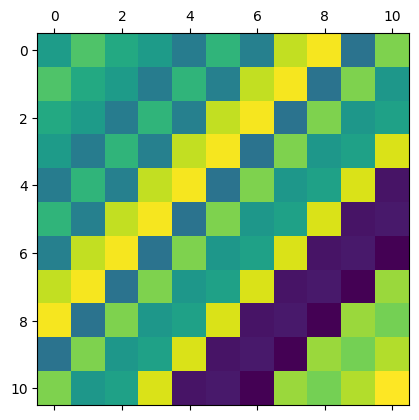

In [32]:
# For free pump, constraints on Hankel form not implemented yet
plt.matshow(np.real(opt_beta))

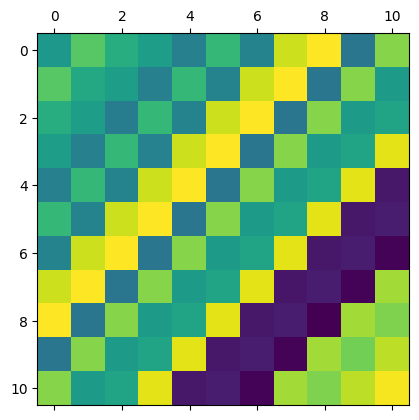

In [33]:
# It reads the exponential relation? When the pump is a diagonal matrix, it does
# Diagonal elements of theoretical U_plus 
# Maximizes the negative of sum of Schimdt number?
plt.matshow((np.real((1/np.sqrt(n))*scipy.linalg.expm((delta_k + opt_beta)*z[-1]))) - np.real((1/np.sqrt(n))*np.eye(N_omega)))

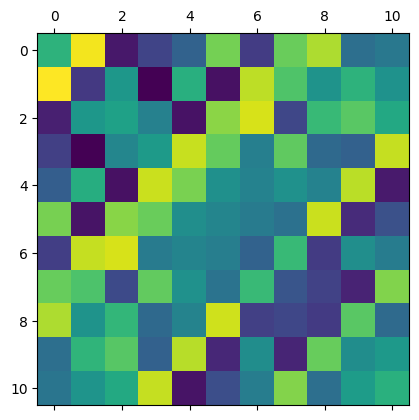

In [34]:
plt.matshow(np.real(opt_U_plus_dagger_1) - np.real((0.0048/np.sqrt(n))*np.eye(N_omega)))

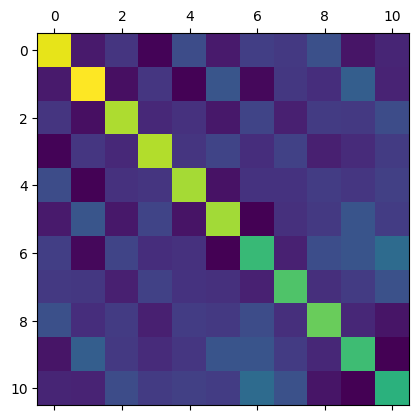

In [35]:
# The B@B_dagger@U_plus from optimization
plt.matshow(np.real(opt_unit@opt_U_plus_dagger_1))

In [36]:
# Theoretical verification of Lippman-Schwinger
proj = (projections[3*N_omega + 3])
test_lin = 0.5*np.trace(proj.conj().T@W_plus[-1].conj().T + proj@W_plus[-1])
green_f_list = api.get_green_f(omega, z)
green_f_list.reverse()
green_f_list[0] = 0.5*green_f_list[0]
green_f_list[-1] = 0.5*green_f_list[-1]
test_quad_normal = 0.5*delta_z*np.trace(sum([W_plus[i].conj().T@proj.conj().T@green_f_list[i].conj().T@beta for i in range(len(W_plus))]))
test_quad_dagger = 0.5*delta_z*np.trace(sum([beta.conj().T@green_f_list[i]@proj@W_plus[i] for i in range(len(W_plus))]))
test_quad = test_quad_normal + test_quad_dagger
test_cst = (1/np.sqrt(n))*np.trace(proj.conj().T@green_f_list[0].conj().T@rand_unitary + green_f_list[0]@proj@rand_unitary.conj().T)

In [37]:
test_lin, test_quad, test_cst, - test_lin + test_quad + test_cst

((2.1174363891107575+0j),
 (0.06458118802822625-1.5881867761018131e-22j),
 (1.936808850115464+0j),
 (-0.11604635096706706-1.5881867761018131e-22j))